In [8]:
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot
import awkward as ak
import vector


# Test some compressor configurations

We want to see how using the SPERR lossy compressor impacts our calculation of the Z boson mass.

We will need to tell LossBench which data to compress. 

We specify the location of the file, the TTree in the file, and the variables we will use for the mass calculation.

In [9]:
lossbench_path = "/home/abelo/lossbench/build/lossbench"

input_file = "/home/abelo/data/ODEO_FEB2025_v0_2muons_data15_periodD.2muons.root"
tree = "analysis"
branches = [
    # "jet_pt", "jet_eta", "jet_phi",
    "lep_pt", "lep_eta", "lep_phi", "lep_e"
]

We will also need to tell LossBench which compressor to use, and how to configure that compressor.

We will be testing SPERR in bpp mode. Bpp stands for "bits-per-pixel", and controls how many bits are used to encode each compressed value. We will test the effect of compressing the data to representations that use only 16, 12, 8, or 4 bits.

We will use a chunk size of 1024 bytes, meaning that we feed data into the SPERR compressor 1024 bytes (1 KB) at a time. This is small! Prior testing has shown that optimal configurations of SPERR use a chunk size of 1024.

In [10]:
compressor = "sperr"
chunk_size = "1024"
mode = "bpp"
precisions = [4, 8, 12, 16]

Now that we've figured out our test configurations, we'll build a list of commands that we can run with with `subprocess` module.

LossBench can be given tests through the command line, or through config files. If you want to test a large number of compressor configurations on the same data, it's more efficient to use a config file - then the data only has to be read once for all of the tests. The CLI is suitable for specifying small numbers of tests, though, and that's exactly what we're doing here: running only 4 tests with 4 different settings of one of SPERR's parameters.

In [11]:
results_file = "results.jsonl"

commands, decomp_files = [], []
for precision in precisions:
    out_file = f"sperr_modebpp_precision{precision}"
    command = [
        lossbench_path,
        "--inputFile", input_file,
        "--tree", tree,
        "--branches", ",".join(branches),
        "--chunkSize", chunk_size,
        "--compressor", f"{compressor}:{mode}={precision}",
        "--resultsFile", f"/home/abelo/lossbench-experiments/notebooks/{results_file}",
        "--decompFile", f"/home/abelo/lossbench-experiments/notebooks/{out_file}.root"
    ]
    
    commands.append(command)
    decomp_files.append(f"/home/abelo/lossbench-experiments/notebooks/{out_file}.root")
    
# Clean up
subprocess.run(["rm", "-f", f"/home/abelo/lossbench-experiments/notebooks/{results_file}"], check=True)
for file in decomp_files:
    subprocess.run(["rm", "-f", f"/home/abelo/lossbench-experiments/notebooks/{file}"], check=True)

# Run commands
for cmd in commands:
    subprocess.run(cmd, check=True)

Reading data for branch 'lep_pt'...
  Compressing branch 'lep_pt' with compressor 'sperr' (bpp=4)...
  Appended results to /home/abelo/lossbench-experiments/notebooks/results.jsonl
  Created /home/abelo/lossbench-experiments/notebooks/sperr_modebpp_precision4.root with branch 'lep_pt'
Reading data for branch 'lep_eta'...
  Compressing branch 'lep_eta' with compressor 'sperr' (bpp=4)...
  Appended results to /home/abelo/lossbench-experiments/notebooks/results.jsonl
  Added branch 'lep_eta' to /home/abelo/lossbench-experiments/notebooks/sperr_modebpp_precision4.root
Reading data for branch 'lep_phi'...
  Compressing branch 'lep_phi' with compressor 'sperr' (bpp=4)...
  Appended results to /home/abelo/lossbench-experiments/notebooks/results.jsonl
  Added branch 'lep_phi' to /home/abelo/lossbench-experiments/notebooks/sperr_modebpp_precision4.root
Reading data for branch 'lep_e'...
  Compressing branch 'lep_e' with compressor 'sperr' (bpp=4)...
  Appended results to /home/abelo/lossbench-e

# Look at results

We specified a single file `results.jsonl` to store the results of all of our tests. We can load that into a Pandas DataFrame using `pd.read_json()` with `lines=True`, and then normalizing to expand nested JSON entries. The result is a `DataFrame` where each row contains compression measurements for every (branch, compressor configuration) that we tested. 

In [12]:
# Load results.jsonl
raw = pd.read_json("results.jsonl", lines=True)
df = pd.json_normalize(raw.to_dict(orient='records'), sep='.')

df

,config.branches,config.chunk_size,config.compressor,config.compressor_config.mode,config.compressor_config.nthreads,config.compressor_config.quality,config.decomp_file,config.input_file,config.iterations,config.results_file,...,results.psnr,results.q50_shift,results.q5_shift,results.q95_shift,results.q99_shift,results.rel_error_avg,results.rel_error_max,results.wasserstein_distance,system.host,system.timestamp
0,lep_pt,1024,sperr,bpp,0,4.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,54.640995,0.212574,1.070899,0.254936,0.039398,0.078778,0.638011,0.361770,Niamh,2026-02-20 16:54:39
1,lep_eta,1024,sperr,bpp,0,4.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,30.688372,0.021031,0.022310,0.024638,0.052323,0.324601,1247.328369,0.038701,Niamh,2026-02-20 16:54:39
2,lep_phi,1024,sperr,bpp,0,4.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,30.397501,0.010902,0.075072,0.030007,0.041080,3.586205,820267.125000,0.063584,Niamh,2026-02-20 16:54:40
3,lep_e,1024,sperr,bpp,0,4.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,50.548634,0.553722,1.615167,0.361694,0.300140,0.118651,1.562354,0.878369,Niamh,2026-02-20 16:54:41
4,lep_pt,1024,sperr,bpp,0,8.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,78.794182,0.003483,0.000658,0.016602,0.020264,0.004951,0.043944,0.005343,Niamh,2026-02-20 16:54:42
5,lep_eta,1024,sperr,bpp,0,8.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,54.806091,0.000190,0.000057,0.000443,0.000736,0.023319,388.801300,0.000381,Niamh,2026-02-20 16:54:43
6,lep_phi,1024,sperr,bpp,0,8.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,54.430367,0.000238,0.000519,0.000973,0.001835,0.222735,48809.691406,0.000577,Niamh,2026-02-20 16:54:44
7,lep_e,1024,sperr,bpp,0,8.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,74.797455,0.007805,0.011468,0.016174,0.029099,0.007411,0.105857,0.013155,Niamh,2026-02-20 16:54:45
8,lep_pt,1024,sperr,bpp,0,12.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,102.869804,0.000734,0.000388,0.003479,0.004845,0.000310,0.003043,0.000879,Niamh,2026-02-20 16:54:46
9,lep_eta,1024,sperr,bpp,0,12.000000,/home/abelo/lossbench-experiments/notebooks/sp...,/home/abelo/data/ODEO_FEB2025_v0_2muons_data15...,1,/home/abelo/lossbench-experiments/notebooks/re...,...,78.876785,0.000014,0.000121,0.000084,0.000125,0.001405,12.372758,0.000077,Niamh,2026-02-20 16:54:47


# Plot distributions

Now that we have put the data through lossy compression, we can visualize the distributions to see how they were affected.

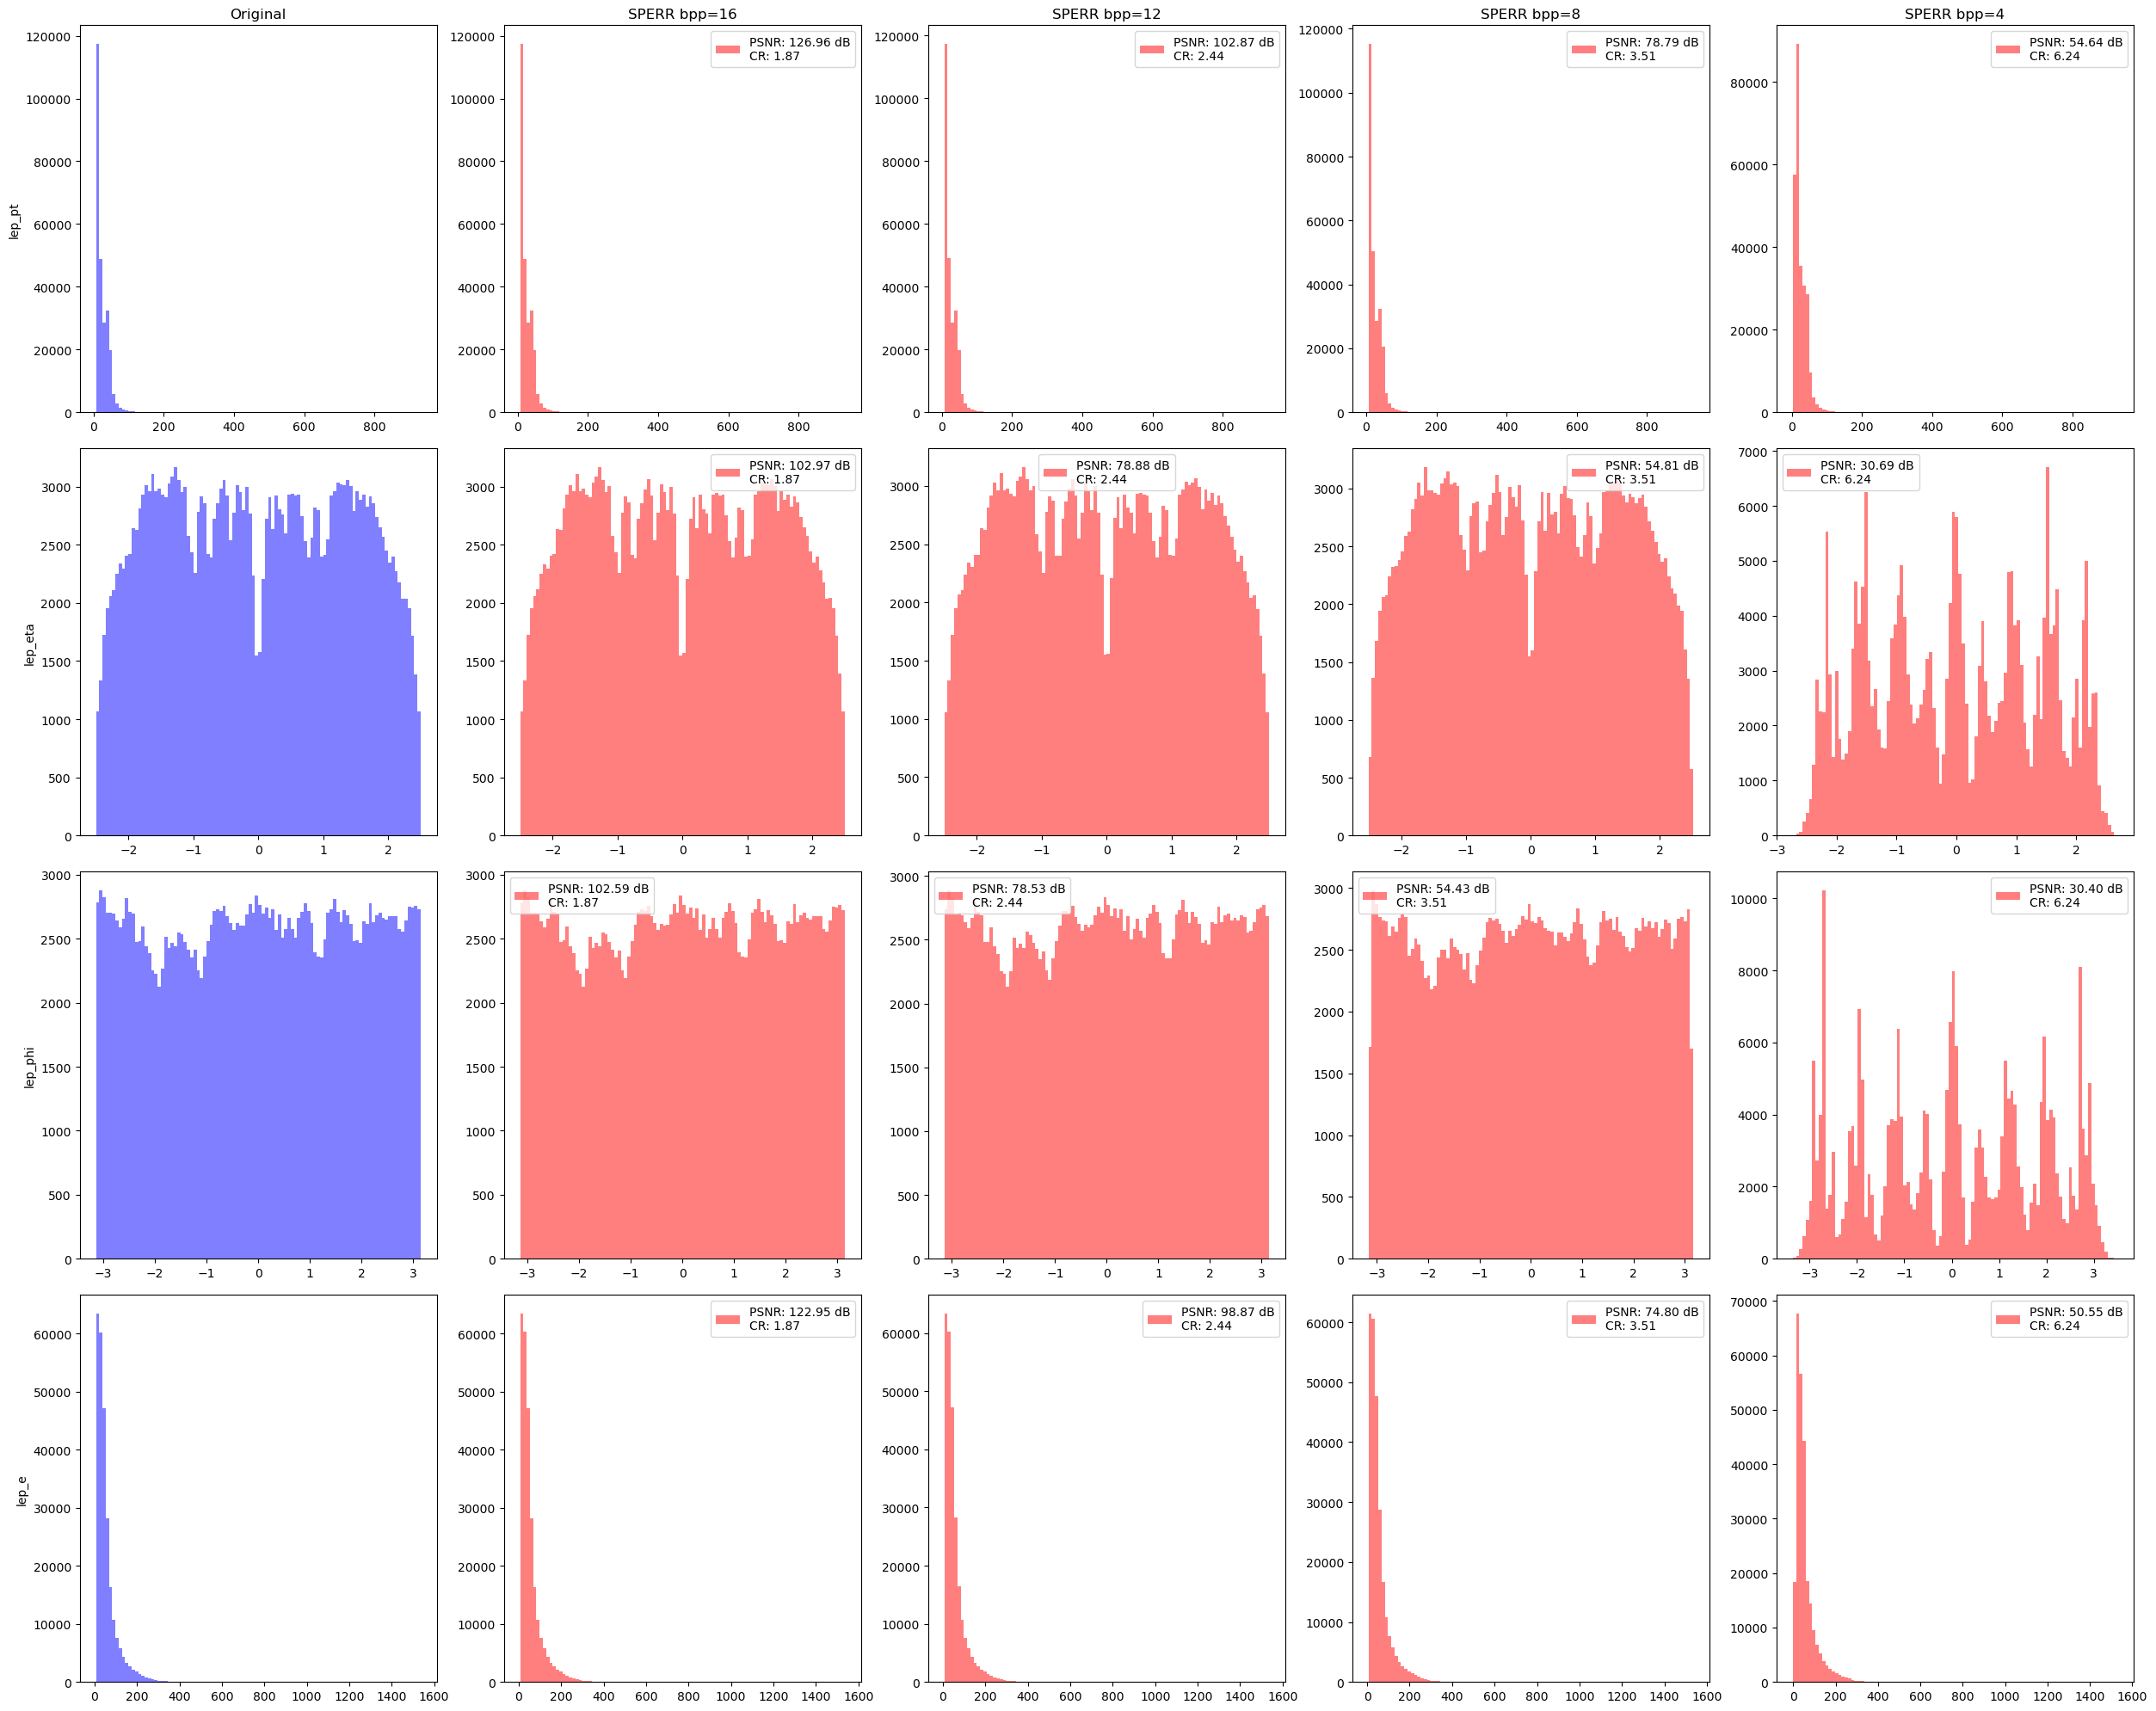

In [13]:
import uproot
import awkward as ak

raw = pd.read_json('results.jsonl', lines=True)
df = pd.json_normalize(raw.to_dict(orient="records"), sep=".")

num_rows = df['config.branches'].nunique()
num_cols = df['config.compressor_config.quality'].nunique() + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

df['config.compressor_config.quality'] = df['config.compressor_config.quality'].astype('float')
df.sort_values(['config.compressor_config.quality'], ascending=False, inplace=True)

for i in range(num_rows):
    branch = df['config.branches'].unique()[i]
    
    for j in range(num_cols):
        ax = axes[i, j]
        if j == 0:
            # Load original branch data
            input_file = df['config.input_file'].iloc[0]
            tree = df['config.tree'].iloc[0]
            f = uproot.open(input_file)
            og_data = f[tree][branch].array()
            
            # Plot original distribution
            axes[i, j].hist(
                ak.flatten(og_data), 
                bins=100,
                alpha=0.5, color='blue',
            )
            
            # Add title if first row
            if i == 0:
                ax.set_title('Original')
                
            # Add y-label if first column
            ax.set_ylabel(branch)
            
        else:
            quality = df['config.compressor_config.quality'].unique()[j - 1]
            
            # Load decompressed data from ROOT file
            row = df[
                (df['config.branches'] == branch) & 
                (df['config.compressor_config.quality'] == quality)
            ].iloc[0]
            
            decomp_file = row['config.decomp_file']
            f = uproot.open(decomp_file)
            decomp_data = f[tree][branch].array()
            
            # Plot decompressed distribution
            axes[i, j].hist(
                ak.flatten(decomp_data), 
                bins=100,
                alpha=0.5, color='red',
                label=f"PSNR: {row['results.psnr']:.2f} dB\nCR: {row['results.compression_ratio']:.2f}"
            )
            
            ax.legend()
            
            # Add title if first row
            if i == 0:
                label = f"SPERR bpp={quality:.0f}"
                ax.set_title(label)

        
plt.tight_layout()
plt.show()

Visually, it looks like SPERR with `bpp=16`, `bpp=12`, and `bpp=8` all preserve the original distribution. At `bpp=4`, things start to look very wrong, particularly for lep_eta and lep_phi. 

At `bpp=16`, we see only modest gains in compression - a compression ratio (CR) of 1.87 - the current value using lossless compression is about 1.45. At `bpp=12` and `bpp=8`, we're getting much more useful compression rates of 2.44 and 3.51, while apparently still preserving the quality of our data.

One thing to note about SPERR's bpp mode is that, because each compressed value has the same fixed size (16, 12, 8, or 4), we see the same compression ratio for every variable. Essentially, we are calculating the space savings by going from storing every value as a 32-bit float to a 16-/12-/8-/4-bit binary value. 

When we compress with an *error bound*, i.e. compress so that all data stays within 0.1 of its original value, we see that compression ratio is different for every variable. This presents a challenge: how do we efficiently find the best compressor configuration for each variable? Alternatively, how do we a compressor configuration that works reasonably well (good compression, low change in distribution) for *every variable*? 

# Find the Z

The real test of data quality is to run an analysis! We will follow the steps in [this notebook](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/Find_the_Z.ipynb) to see if we can correctly estimate the mass of the Z boson using each set of our decompressed data.

Calculating with data from ODEO_FEB2025_v0_2muons_data15_periodD.2muons.root
Calculating with data from sperr_modebpp_precision16.root
Calculating with data from sperr_modebpp_precision12.root
Calculating with data from sperr_modebpp_precision8.root
Calculating with data from sperr_modebpp_precision4.root


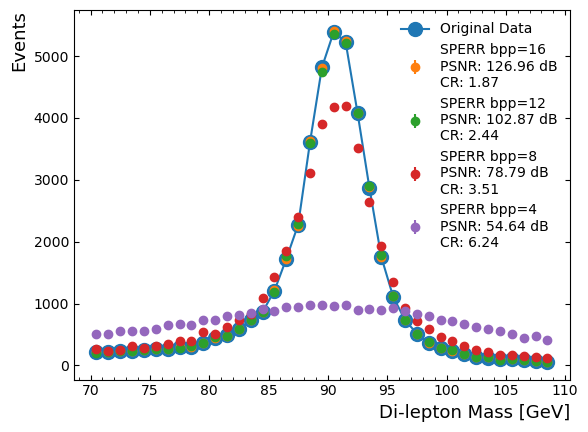

In [23]:
import uproot
import awkward as ak

def calculate_invariant_masses(file):
    tree = uproot.open(file + ":analysis")
    numevents = tree.num_entries
    
    data_iterator = tree.iterate(
        ['lep_pt', 'lep_eta', 'lep_phi', 'lep_e'],
        library='ak'
    )
    
    masses = []
    for data in data_iterator:
        mask = ak.num(data.lep_pt) == 2
        data = data[mask]
        
        p4 = vector.zip({'pt': data.lep_pt, 'eta': data.lep_eta, 'phi': data.lep_phi, 'e': data.lep_e})
        invariant_mass = (p4[:, 0] + p4[:, 1]).M
        masses.append(invariant_mass)
        
    return ak.concatenate(masses)

raw = pd.read_json('results.jsonl', lines=True)
df = pd.json_normalize(raw.to_dict(orient="records"), sep=".")

df['config.compressor_config.quality'] = df['config.compressor_config.quality'].astype('float')
df.sort_values(['config.compressor_config.quality'], inplace=True, ascending=False)

files = [df['config.input_file'].iloc[0]]
files.extend(list(df['config.decomp_file'].unique()))

masses_dict = {}

for file in files:
    print(f"Calculating with data from {file.split("/")[-1]}")
    
    masses_dict[file] = calculate_invariant_masses(file)
    
    
for file, full_masses in masses_dict.items():
    # Calculate mass histogram
    bin_edges = np.arange(start=70, stop=110, step=1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    data_x, _ = np.histogram(ak.to_numpy(full_masses), bins=bin_edges)
    data_x_errors = np.sqrt(data_x)

    # Plot histogram
    main_axes = plt.gca()

    if file == df['config.input_file'].iloc[0]:
        label = "Original Data"
        
        main_axes.errorbar(
            x=bin_centers, y=data_x, yerr=data_x_errors,
            fmt='o-', markersize=10, label=label
        )
    else:
        row = df[df['config.decomp_file'] == file].iloc[0]
        quality = df[df['config.decomp_file'] == file]['config.compressor_config.quality'].iloc[0]
        label = f"SPERR bpp={quality:.0f}\nPSNR: {row['results.psnr']:.2f} dB\nCR: {row['results.compression_ratio']:.2f}"

        main_axes.errorbar(
            x=bin_centers, y=data_x, yerr=data_x_errors,
            fmt='o', label=label
        )

    main_axes.tick_params(
        which='both', direction='in',
        top=True, right=True
    )

    main_axes.set_xlabel(
        "Di-lepton Mass [GeV]",
        fontsize=13, x=1, horizontalalignment='right'
    )
    
    main_axes.set_ylabel(
        'Events',
        fontsize=13, y=1, horizontalalignment='right'
    )
    
    # main_axes.set_yscale('log')
    from matplotlib.ticker import AutoMinorLocator    
    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.legend(frameon=False)

    # Plot fit
    # y_fit = voight_model(m_fit, *params)
    # main_axes.plot(m_fit, y_fit, 'r-', label='Fit')
    # main_axes.legend(frameon=False)

This is informative! It looks like at `bpp=16` and `bpp=12`, our original result is reproduced well. It's hard to tell exactly how much the peak shifts *horizontally* at `bpp=8`, but it is clearly starting to deflate vertically. At `bpp=4`, the distribution has flattened out almost completely.